# architecture-16 ( Basic Regression ) v-1

## What's new:

1- Add unsupervised learning

## Next steps
1- Add df = df.sort_values(by=['DATE', 'TIME']) ?????


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras import callbacks

In [3]:
df = pd.read_csv('datasets-16/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [4]:
# Scaling Features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df[['<CLOSE>']])

In [5]:
# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)


WINDOW_SIZE = 60
FORECAST_HORIZON = 10

X, y = create_sequences(scaled, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
# === Phase 1: Unsupervised Pretraining using LSTM Autoencoder ===
def build_lstm_autoencoder(timesteps, features, latent_dim):
    inputs = Input(shape=(timesteps, features))
    encoded = LSTM(latent_dim)(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(features, return_sequences=True)(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

latent_dim = 32
autoencoder, encoder = build_lstm_autoencoder(WINDOW_SIZE, X_train.shape[2], latent_dim)

print("Pretraining autoencoder...")
autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)

I0000 00:00:1753020281.197720    8721 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1537 MB memory:  -> device: 0, name: NVIDIA GeForce MX330, pci bus id: 0000:02:00.0, compute capability: 6.1


Pretraining autoencoder...
Epoch 1/30


I0000 00:00:1753020284.252265    8823 cuda_dnn.cc:529] Loaded cuDNN version 91001


551/551 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0116 - val_loss: 0.0023
Epoch 2/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 7.1744e-04 - val_loss: 6.5073e-04
Epoch 3/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.9431e-04 - val_loss: 9.5777e-04
Epoch 4/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 5.7368e-04 - val_loss: 4.6253e-04
Epoch 5/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.5980e-04 - val_loss: 0.0024
Epoch 6/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.9163e-04 - val_loss: 4.2508e-04
Epoch 7/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.6041e-04 - val_loss: 4.3627e-04
Epoch 8/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.6718e-04 - val_loss: 3.9215e-04
Epoch 9/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.6696e-04 - val_loss: 3.7719e-04
Epoch 10/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.5879e-04 - val_loss: 3.5336e-04
Epoch 11/30
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.5129e-04

In [7]:
# === Phase 2: Supervised Fine-tuning ===
# Create LSTM model and initialize LSTM weights from encoder
def build_forecasting_model_functional(input_shape, encoder_model, forecast_horizon):
    inputs = Input(shape=input_shape)

    # Step 1: Create LSTM layer
    pretrained_lstm = LSTM(latent_dim, name="pretrained_lstm")

    # Step 2: Manually build the layer so it has initialized weights
    pretrained_lstm.build((None, *input_shape))  # Batch size None, then (timesteps, features)

    # Step 3: Set pretrained weights
    pretrained_lstm.set_weights(encoder_model.layers[1].get_weights())

    # Step 4: Apply the layer to input
    x = pretrained_lstm(inputs)
    outputs = Dense(forecast_horizon)(x)

    # Step 5: Create model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

model = build_forecasting_model_functional((X_train.shape[1], X_train.shape[2]), encoder, FORECAST_HORIZON)

In [8]:
# === Train forecasting model ===
mc = callbacks.ModelCheckpoint(filepath='mcp_saved_model.keras', monitor='val_loss', save_best_only=True)
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Fine-tuning with supervised learning...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[mc, es],
    verbose=1
)

Fine-tuning with supervised learning...
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0471 - mae: 0.1021 - val_loss: 5.3715e-04 - val_mae: 0.0179
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.2975e-04 - mae: 0.0100 - val_loss: 3.9142e-04 - val_mae: 0.0147
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.5838e-04 - mae: 0.0080 - val_loss: 3.9822e-04 - val_mae: 0.0153
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3214e-04 - mae: 0.0072 - val_loss: 2.8010e-04 - val_mae: 0.0125
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1944e-04 - mae: 0.0068 - val_loss: 2.1384e-04 - val_mae: 0.0106
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.1013e-04 - mae: 0.0064 - val_loss: 2.5322e-04 - val_mae: 0.0117
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0176e-04 - mae: 0.0062 - val_loss: 8.5350e-04 - val_mae: 0.0251
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1785e-04 - mae: 0.00

In [9]:
# === Load the last 60 rows from a separate CSV file for prediction ===
input_df = pd.read_csv('datasets-16/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
                       sep='\t').dropna()
input_scaled = scaler.transform(
    input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 5)

# === Predict the next 10 candles + Inverse scale ===
pred = model.predict(input_sequence)
prediction = close_scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


# plot section

In [10]:
import sys

sys.path.insert(1, '../../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-16/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-16/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

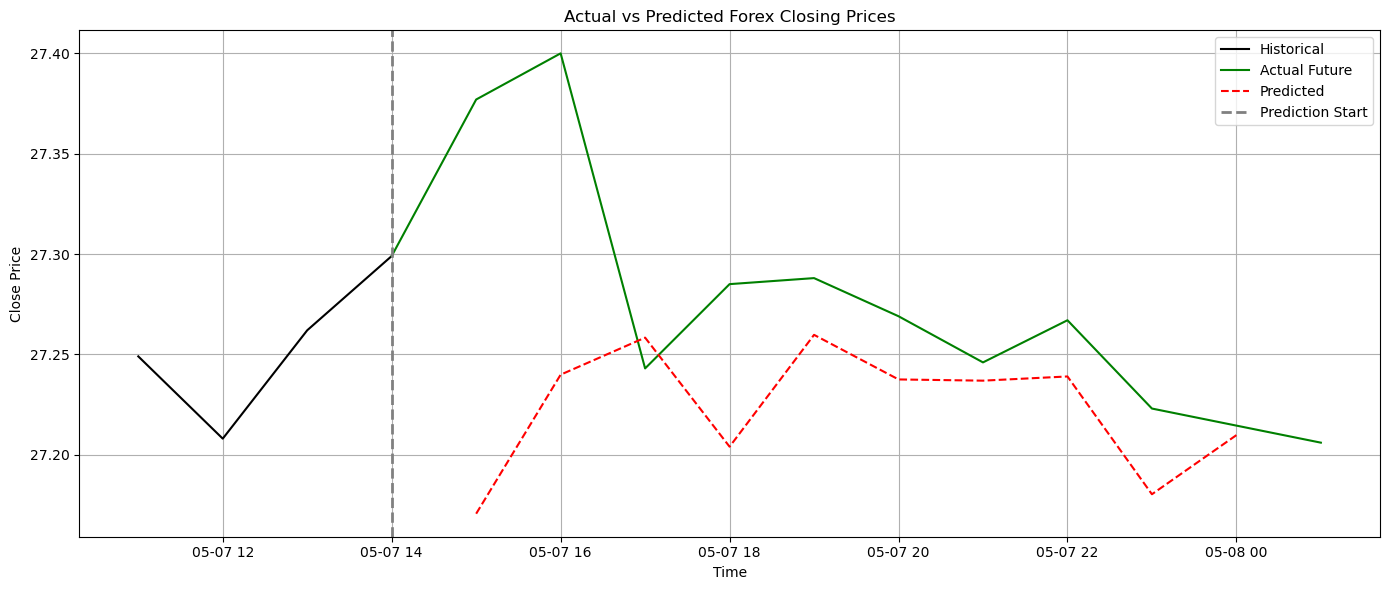

In [11]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [12]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
